# Classification using random forest and multi-layer perceptron

Classification using two algorithms and comparing performance. Example using small synthetic data set (without nested cross-validation).


## Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.datasets import make_classification 
from sklearn.neural_network import MLPClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, balanced_accuracy_score 
from sklearn import metrics 
from statsmodels.stats import contingency_tables 
import statsmodels.api as sm 
from statsmodels.graphics.factorplots import interaction_plot

In [2]:
#parameters for size/resolution of plots
%matplotlib inline
a4_dims = (9.7, 3.27)
plt.rcParams['figure.dpi'] = 500
plt.rcParams['savefig.dpi'] = 500
plt.rcParams["figure.autolayout"] = True

## Load data

In [3]:
#read csv dataset
dataframe = pd.read_csv('data1.csv')

#print first 5 rows of dataset
dataframe.head(5)

,age,sex,group,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10
0,38,0,0,0.071,0.058,0.537,0.129,0.468,0.275,0.216,0.189,0.379,0.048
1,38,0,0,0.021,0.315,0.454,0.268,0.093,0.355,0.176,0.006,0.032,0.538
2,34,0,0,0.526,0.369,0.158,0.267,0.202,0.035,0.363,0.182,0.147,0.388
3,38,0,0,0.176,0.018,0.532,0.508,0.079,0.386,0.454,0.113,0.453,0.142
4,37,0,0,0.144,0.428,0.117,0.199,0.325,0.340,0.374,0.423,0.115,0.217


## Describe data

In [4]:
#look for potential outliers in data
dataframe.describe()

,age,sex,group,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,42.350000,0.500000,0.500000,0.358740,0.369120,0.39111,0.344980,0.394300,0.401980,0.416450,0.394620,0.430800,0.367590
std,11.403858,0.502519,0.502519,0.250068,0.268282,0.25935,0.247038,0.258359,0.278156,0.284908,0.289115,0.272723,0.242346
min,20.000000,0.000000,0.000000,0.002000,0.003000,0.01000,0.001000,0.001000,0.005000,0.002000,0.002000,0.016000,0.010000
25%,31.750000,0.000000,0.000000,0.175250,0.168250,0.18325,0.142750,0.188750,0.179250,0.200250,0.134750,0.217500,0.168500
50%,44.000000,0.500000,0.500000,0.332500,0.319000,0.34850,0.310000,0.352500,0.356000,0.331000,0.375000,0.378500,0.328500
75%,51.000000,1.000000,1.000000,0.459750,0.469750,0.53325,0.491250,0.562500,0.547000,0.578500,0.570750,0.580500,0.532750
max,60.000000,1.000000,1.000000,1.015000,1.013000,1.00900,0.967000,0.934000,1.001000,1.019000,0.993000,1.018000,0.980000


## Adjust for confounding effects

In [5]:
#calculate mean age as reference point
mean_age = np.mean(dataframe['age'])

reference_sex = 0

#input features to be adjusted for confounding effects
features_to_residualize = ['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 
                           'Feature6', 'Feature7', 'Feature8', 'Feature9', 'Feature10']
                           
for feature in features_to_residualize:
    #target variable to model
    targ = dataframe[feature]
    
    #intercept/constant - mean value of response variable when all predictor variables are equal to zero
    dataframe["Intercept"] = 1
    
    #covariates confounding explanatory variables
    conf = dataframe[["Intercept", "sex", "age"]]
    
    #generalized linear model
    md = sm.GLM(targ, conf, family=sm.families.Gaussian())

    #fit regression model
    md = md.fit()
    print(md.summary())
    
    #adjusted features
    feature_name = feature + '_prime'

    #calculate residual variables that end in 'prime'
    dataframe[feature_name] = dataframe[feature] - (md.params[1] * (dataframe["sex"] - reference_sex) + 
                                                        md.params[2] * (dataframe["age"] - mean_age))

print('Residualization complete!')

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Feature1   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                        0.061785
Method:                          IRLS   Log-Likelihood:                -1.1661
Date:                Fri, 19 Apr 2024   Deviance:                       5.9931
Time:                        17:42:35   Pearson chi2:                     5.99
No. Iterations:                     3   Pseudo R-squ. (CS):            0.03194
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5178      0.099      5.237      0.0

In [6]:
#get dataframes for group0 and group1 after data pre-processing
group0 = dataframe[dataframe['group']== 0]
group1 = dataframe[dataframe['group']== 1]

## Group Classification 

In [7]:
#preparing data for classification

#features (after adjustment) for classifying group0 vs group1
features_for_classification = ['Feature1_prime', 'Feature2_prime', 'Feature3_prime', 'Feature4_prime', 'Feature5_prime', 
                           'Feature6_prime', 'Feature7_prime', 'Feature8_prime', 'Feature9_prime', 'Feature10_prime']

#input features for training
X = dataframe[features_for_classification]

#class label
Y = dataframe['group']

#transform labels from 'YES'/'NO' to dummy coding (if necessary)
Y = pd.get_dummies(Y)

## Random Forest Classifier

In [8]:
#split to train/test sets - same data splits for the two classifiers
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state=3)
Y_test = Y_test.values.argmax(axis=1)

#set seed for reproducibility
np.random.seed(seed=2143)

#define random forest classifier
model_1 = RandomForestClassifier(max_depth=3, n_estimators=200, random_state=3)

#fit classifier using training set and labels
model_1.fit(X_train, Y_train)
print('Random Forest has been trained!')

#get predictions of trained model on test set
Y_pred_model_1 = model_1.predict(X_test)
Y_pred_model_1 = Y_pred_model_1.argmax(axis=1)

Random Forest has been trained!


In [9]:
#random forest evaluation

#area under curve
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred_model_1, pos_label=1)
auc_model_1 = metrics.auc(fpr, tpr)
print("Area under the curve: {:.3f}".format(auc_model_1))

#accuracy score
accuracy = accuracy_score(Y_test, Y_pred_model_1)
print("Accuracy: {:.2f}%".format(accuracy * 100))

#balanced accuracy
b_accuracy = balanced_accuracy_score(Y_test, Y_pred_model_1)
print("Balanced Accuracy: {:.2f}%".format(b_accuracy * 100))

Area under the curve: 0.923
Accuracy: 92.00%
Balanced Accuracy: 92.31%


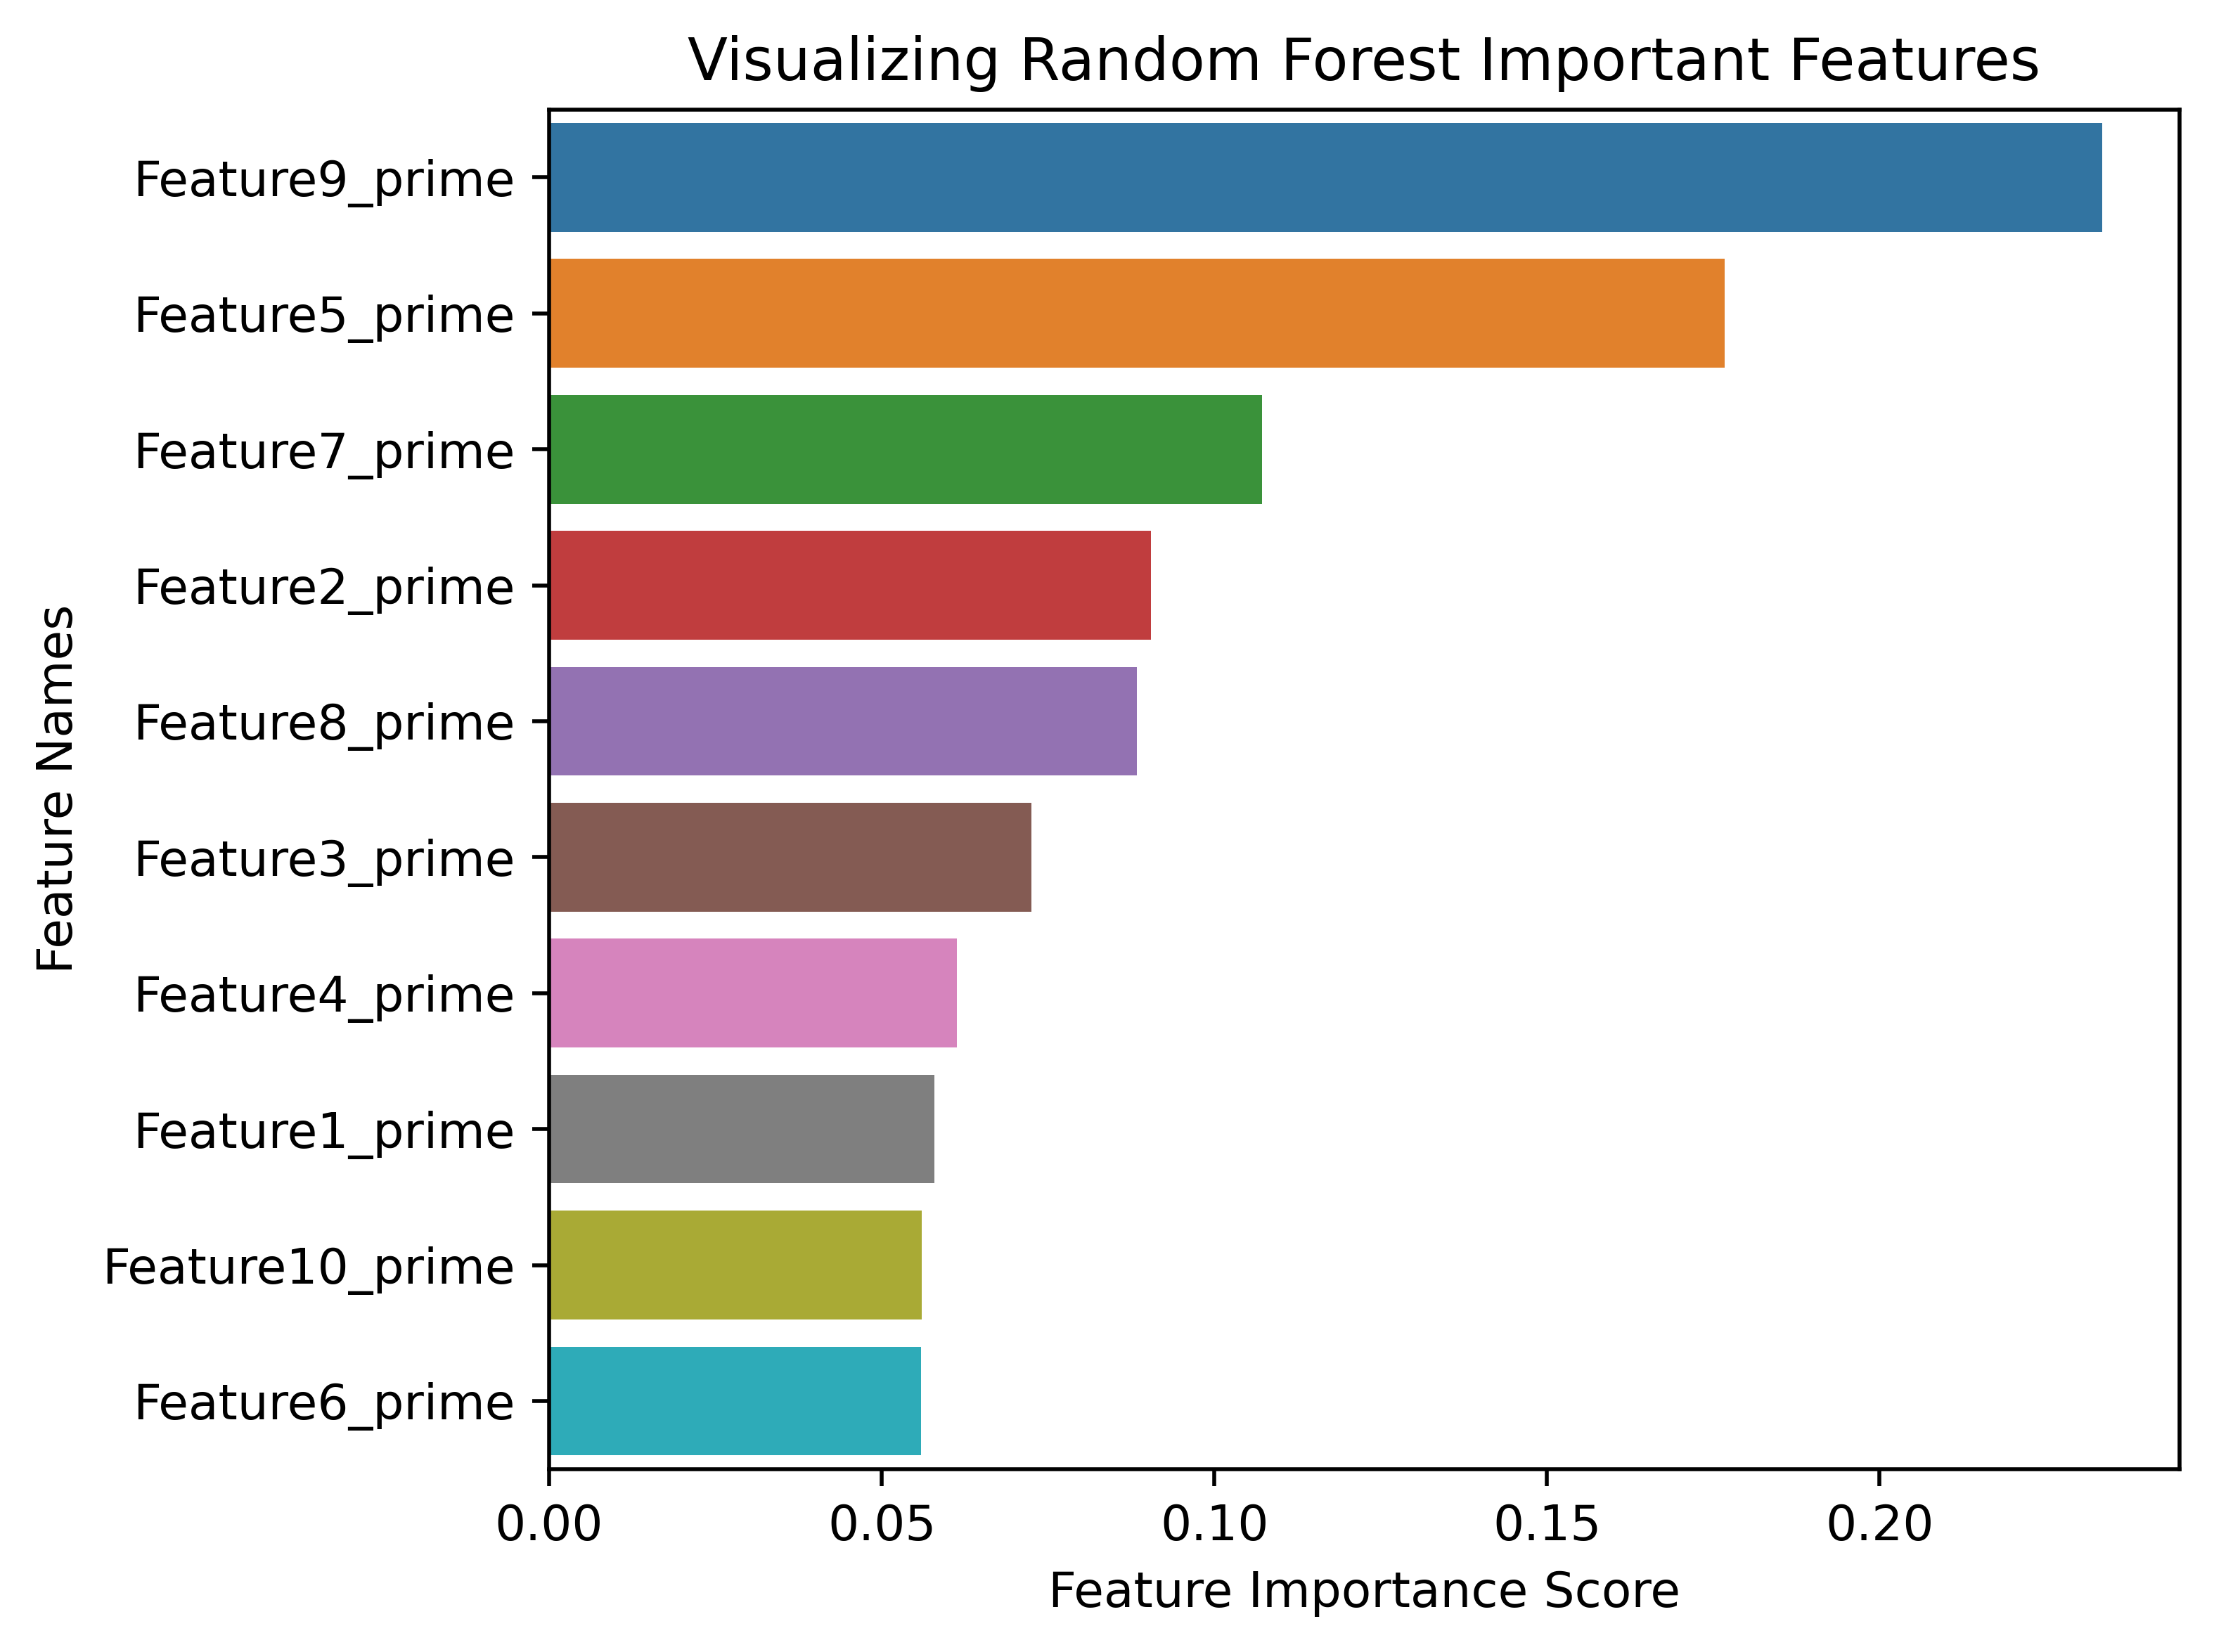

In [10]:
#feature importance with random forest

#get feature names and importances from trained model
feature_names = X.columns
feature_imp = pd.Series(model_1.feature_importances_,index=feature_names.values).sort_values(ascending=False)

#create bar plot
sns.barplot(x=feature_imp[0:10], y=feature_imp.index[0:10])
#add labels to graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature Names')
plt.title("Visualizing Random Forest Important Features")
plt.show()

## Multi-Layer Perceptron (MLP)

In [11]:
#multi-layer perceptron classifier

#set seed for reproducibility
np.random.seed(seed=2143)

#hidden_layer_sizes=(16,8) - two hidden layers, one with 16 neuros and one with 8. total 4 layers
#input (10 features) + hidden layer 1 (16) + hidden layer 2 (8) + output layer (2 outputs for binary classification)
model_2 = MLPClassifier(random_state=3, max_iter=800,verbose=True, hidden_layer_sizes=(16,8))
model_2.fit(X_train, Y_train)

print('Multi-layer perceptron has been trained!')

Y_pred_model_2 = model_2.predict(X_test)

#keep 1 value for prediction, 0 for group0 and 1 for group1
Y_pred_model_2 = Y_pred_model_2.argmax(axis=1)

Iteration 1, loss = 1.39914021
Iteration 2, loss = 1.39659839
Iteration 3, loss = 1.39408568
Iteration 4, loss = 1.39171923
Iteration 5, loss = 1.38955300
Iteration 6, loss = 1.38762734
Iteration 7, loss = 1.38583962
Iteration 8, loss = 1.38422582
Iteration 9, loss = 1.38273444
Iteration 10, loss = 1.38126607
Iteration 11, loss = 1.37979337
Iteration 12, loss = 1.37832352
Iteration 13, loss = 1.37683430
Iteration 14, loss = 1.37533645
Iteration 15, loss = 1.37384426
Iteration 16, loss = 1.37233231
Iteration 17, loss = 1.37078772
Iteration 18, loss = 1.36921138
Iteration 19, loss = 1.36763357
Iteration 20, loss = 1.36603176
Iteration 21, loss = 1.36443554
Iteration 22, loss = 1.36282279
Iteration 23, loss = 1.36120471
Iteration 24, loss = 1.35958680
Iteration 25, loss = 1.35797809
Iteration 26, loss = 1.35634302
Iteration 27, loss = 1.35470592
Iteration 28, loss = 1.35306600
Iteration 29, loss = 1.35138830
Iteration 30, loss = 1.34969251
Iteration 31, loss = 1.34797559
Iteration 32, los

Iteration 262, loss = 0.32360264
Iteration 263, loss = 0.32114546
Iteration 264, loss = 0.31872427
Iteration 265, loss = 0.31633571
Iteration 266, loss = 0.31397064
Iteration 267, loss = 0.31162865
Iteration 268, loss = 0.30931062
Iteration 269, loss = 0.30702300
Iteration 270, loss = 0.30475270
Iteration 271, loss = 0.30250834
Iteration 272, loss = 0.30028859
Iteration 273, loss = 0.29808993
Iteration 274, loss = 0.29591636
Iteration 275, loss = 0.29376125
Iteration 276, loss = 0.29162927
Iteration 277, loss = 0.28951548
Iteration 278, loss = 0.28741463
Iteration 279, loss = 0.28533081
Iteration 280, loss = 0.28326938
Iteration 281, loss = 0.28122753
Iteration 282, loss = 0.27920783
Iteration 283, loss = 0.27721478
Iteration 284, loss = 0.27523895
Iteration 285, loss = 0.27328302
Iteration 286, loss = 0.27134441
Iteration 287, loss = 0.26942445
Iteration 288, loss = 0.26752646
Iteration 289, loss = 0.26564511
Iteration 290, loss = 0.26378265
Iteration 291, loss = 0.26193587
Iteration 

Iteration 753, loss = 0.03320509
Iteration 754, loss = 0.03310010
Iteration 755, loss = 0.03299575
Iteration 756, loss = 0.03289162
Iteration 757, loss = 0.03278776
Iteration 758, loss = 0.03268426
Iteration 759, loss = 0.03258118
Iteration 760, loss = 0.03247903
Iteration 761, loss = 0.03237722
Iteration 762, loss = 0.03227521
Iteration 763, loss = 0.03217435
Iteration 764, loss = 0.03207394
Iteration 765, loss = 0.03197373
Iteration 766, loss = 0.03187376
Iteration 767, loss = 0.03177404
Iteration 768, loss = 0.03167519
Iteration 769, loss = 0.03157630
Iteration 770, loss = 0.03147801
Iteration 771, loss = 0.03138007
Iteration 772, loss = 0.03128234
Iteration 773, loss = 0.03118525
Iteration 774, loss = 0.03108925
Iteration 775, loss = 0.03099271
Iteration 776, loss = 0.03089674
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Multi-layer perceptron has been trained!


In [12]:
#mlp evaluation

#area under curve
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred_model_2, pos_label=1)
auc_model_2 = metrics.auc(fpr, tpr)
print("Area under the curve: {:.3f}".format(auc_model_2))

#accuracy score
accuracy = accuracy_score(Y_test, Y_pred_model_2)
print("Accuracy: {:.2f}%".format(accuracy * 100))

#balanced accuracy
b_accuracy = balanced_accuracy_score(Y_test, Y_pred_model_2)
print("Balanced Accuracy: {:.2f}%".format(b_accuracy * 100))

Area under the curve: 0.881
Accuracy: 88.00%
Balanced Accuracy: 88.14%


## McNemar's Test

In [13]:
#calculate contingency matrix
def contingency_table_calc(y_true, y_1, y_2):
    c1i_c2c = sum(np.logical_and((y_1 != y_true),(y_2 == y_true)))
    c1c_c2i = sum(np.logical_and((y_1 == y_true),(y_2 != y_true)))
    c1c_c2c = sum(np.logical_and((y_1 == y_true),(y_2 == y_true)))
    c1i_c2i = sum(np.logical_and((y_1 != y_true),(y_2 != y_true)))

    contingency_table = [[c1c_c2c, c1c_c2i],[c1i_c2c, c1i_c2i]]

    return contingency_table

contingency_table = contingency_table_calc(Y_test, Y_pred_model_1, Y_pred_model_2)

In [14]:
#compute McNemar statistic and p-value to compare two models
p = contingency_tables.mcnemar(contingency_table, exact=True).pvalue

print("Null Hypothesis: two ML models are equally accurate on same cohort.")
print(f'p-value with NcNemars exact test: {p:.4f}')
if p < 0.05:
    print("p<0.05 --> reject the null hypothesis.")
else:
    print("p>0.05 --> cannot reject the null hypothesis.")

Null Hypothesis: two ML models are equally accurate on same cohort.
p-value with NcNemars exact test: 1.0000
p>0.05 --> cannot reject the null hypothesis.
